## CSCA 5632. Final Project

## Clustering wine samples dataset

In this project we will be trying to predict the quality of wine samples looking at the pure chemical characteristics. Characteristics are continuous floating point numbers, quality is measured in numerical scale 3-9 (worst-to-best), this makes it a regression problem. Two methods to be tried: *Hierarchical clustering* and *K-Means clustering*.

### Dataset Information
Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests. https://archive.ics.uci.edu/dataset/186/wine+quality


### Additional Information
The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Data consists of two datasets with characteristics of red and white wines.

By P. Cortez, A. Cerdeira, Fernando Almeida, Telmo Matos, J. Reis. 2009

In [2]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, pairwise_distances_argmin
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from statsmodels.tools.eval_measures import rmse
from functools import reduce
import operator
import itertools


## Data cleaning, EDA


The dataset consists of two csv files - red and white wines separated. I will be only using one of them - `winequality-white.csv`.

In [3]:
wines = pd.read_csv('./data/winequality-white.csv', sep=';')
wines.sample(n=5)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
3381            6.9              0.19         0.35            6.90      0.045   
4704            6.3              0.36         0.50            8.30      0.053   
4437            6.5              0.29         0.30            9.15      0.051   
58              6.6              0.38         0.15            4.60      0.044   
415             7.3              0.28         0.36           12.70      0.040   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
3381                 51.0                 125.0  0.99330  3.10       0.44   
4704                 51.0                 202.0  0.99550  3.20       0.51   
4437                 25.0                 166.0  0.99339  3.24       0.56   
58                   25.0                  78.0  0.99310  3.11       0.38   
415                  38.0                 140.0  0.99800  3.30       0.79   

      alcohol  quality  
3381    10.70        7  
4704     9.60        6  
4437    11.35        6  
58      10.20        6  
415      9.60        6

In [4]:
wines.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.036000            23.000000            108.000000     0.991723   
50%       0.043000            34.000000            134.000000     0.993740   
75%       0.050000            46.000000            167.000000     0.996100   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  4898.000000  4898.000000  4898.000000  4898.000000  
mean      3.188267     0.489847    10.514267     5.877909  
std       0.151001     0.114126     1.230621     0.885639  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.090000     0.410000     9.500000     5.000000  
50%       3.180000     0.470000    10.400000     6.000000  
75%       3.280000     0.550000    11.400000     6.000000  
max       3.820000     1.080000    14.200000     9.000000

The dataset is dense (complete), there are no missing values. If there were some, then it would be a case by case decision to keep them with imputed defaults or just drop them if the samples look corrupted.

In [5]:
# No missing values!
print(wines.isna().any().any())

False


Two features correlating the most with the target quality are: alcohol and density, but scattering along these dimensions doesn't easily reveal any helpful regularities. We can also see that there are very few "bad" and "exceptional" wines, the majority is in the range 4-8.

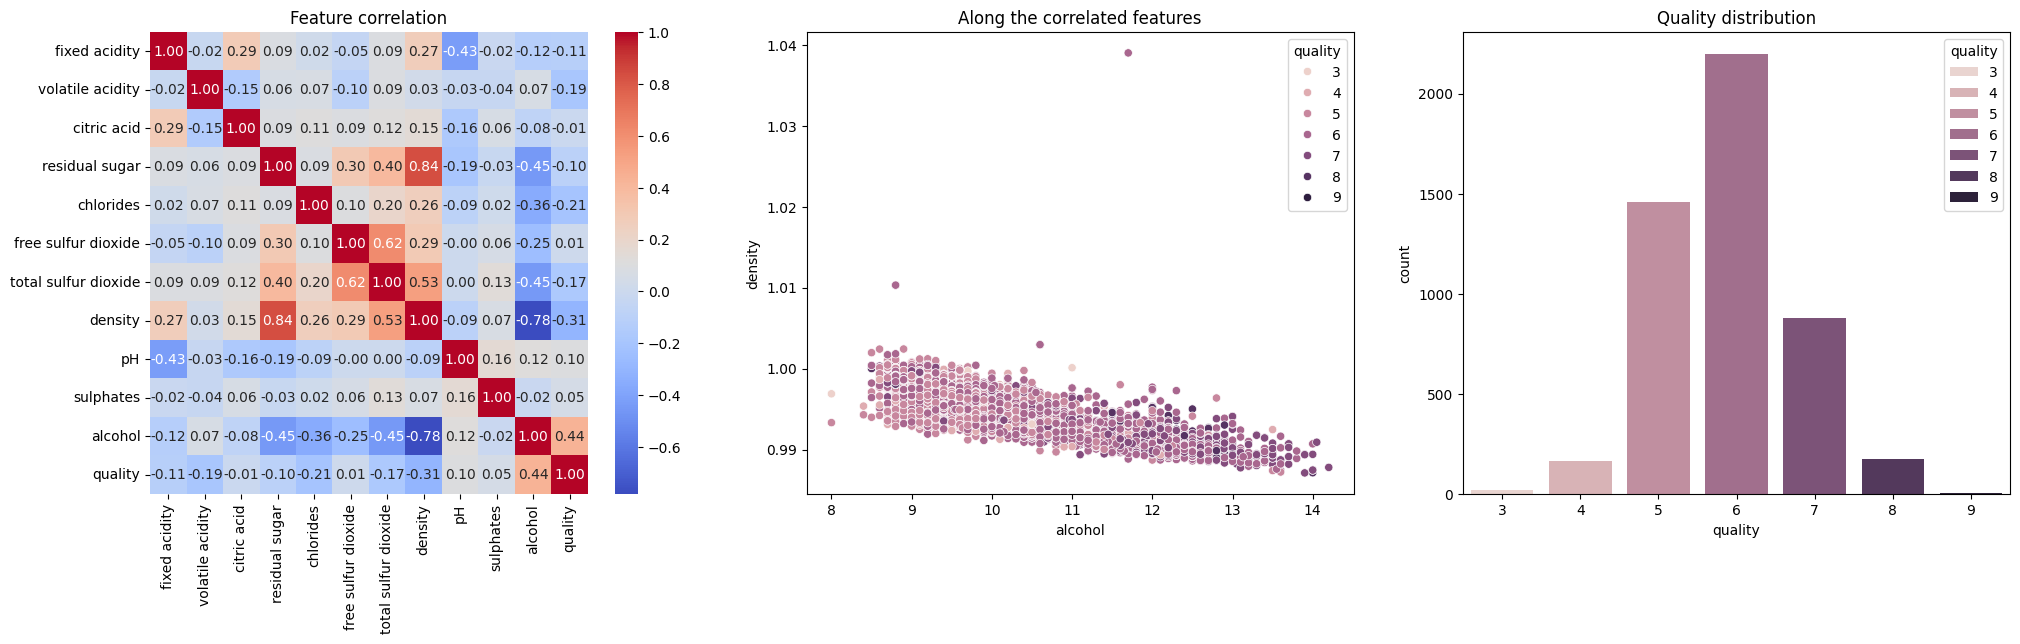

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
sns.heatmap(wines.corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0])
sns.scatterplot(x='alcohol', y='density', hue='quality', data=wines, ax=axes[1])
sns.countplot(data=wines, x='quality', ax=axes[2], hue='quality')
axes[0].set_title("Feature correlation")
axes[1].set_title("Along the correlated features")
axes[2].set_title("Quality distribution")
plt.show()

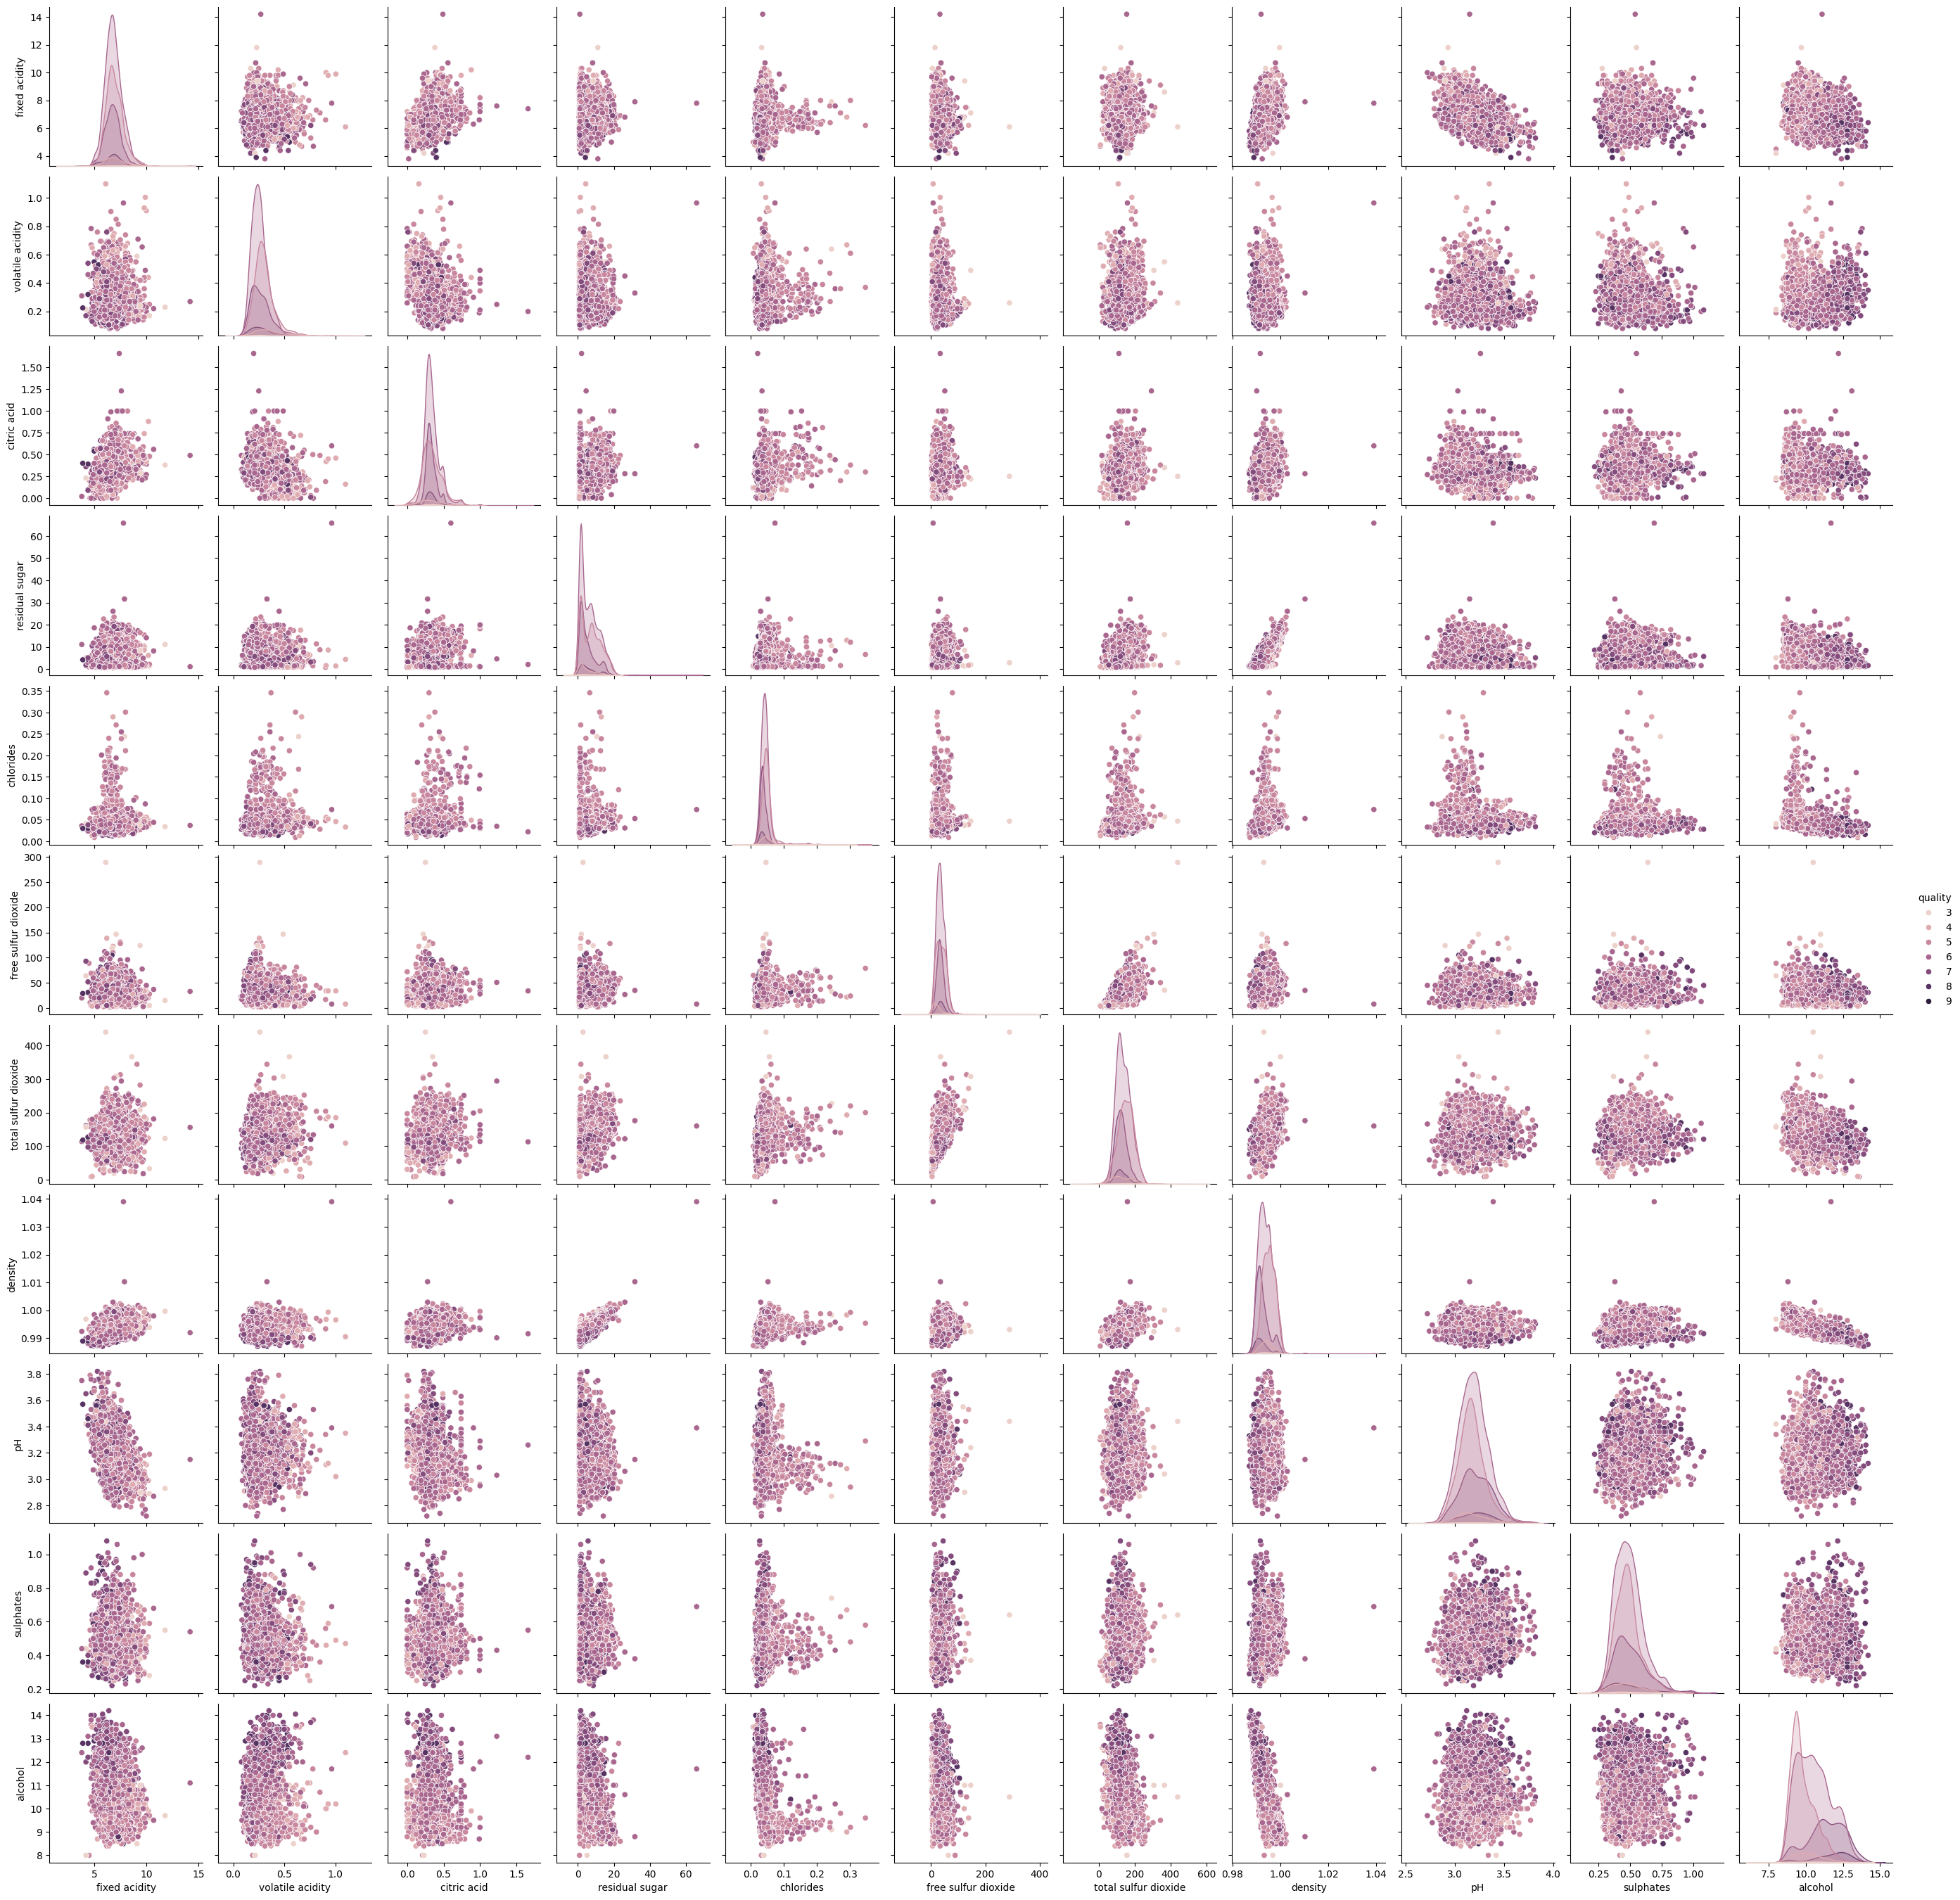

In [5]:
sns.pairplot(wines, diag_kind='kde', hue='quality')

Since the outliers are very far away from the general population, the clustering algorithms will separate them into their own personal clusters which contradicts the purpose of generalizing, it makes sense to strip them from training, but defining and identifying them up front is a little not trivial. If all the features were distributed normally (Gaussian), then everything out of the 3 sigma range could be called an "outlier", but the distributions here are not all normal. Let's just try different multipliers and see how many of the records are affected.

['3*std = 396 (8.08%)', '4*std = 159 (3.25%)', '5*std = 86 (1.76%)', '6*std = 40 (0.82%)', '7*std = 25 (0.51%)', '8*std = 13 (0.27%)', '9*std = 9 (0.18%)', '10*std = 7 (0.14%)']


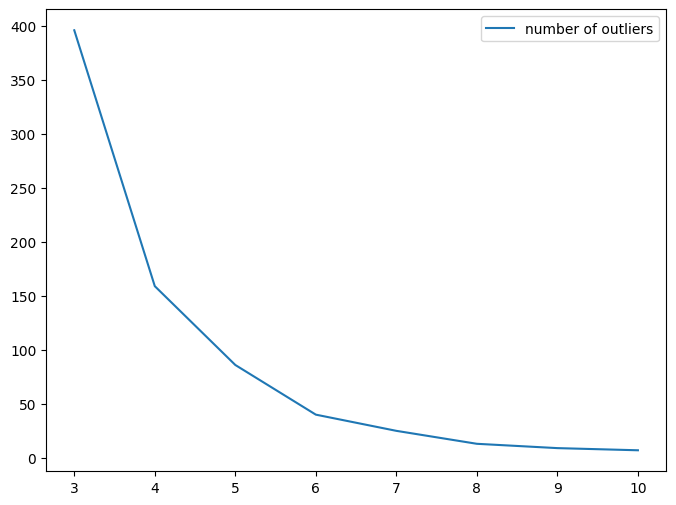

In [6]:
def out_of_k_sigmas(df, df_colums, k):
    conditions = [np.abs(df[c] - df[c].mean()) > k * df[c].std() for c in df_colums]
    return reduce(operator.or_, conditions)

k_sigmas = range(3,11)
n_outliers = []
for k in k_sigmas:
    mask = out_of_k_sigmas(wines, wines.columns[:-1], k)
    n_outliers.append(np.sum(mask))

print([f'{k}*std = {n} ({100*(n/wines.shape[0]):.2f}%)' for k,n in zip(k_sigmas, np.array(n_outliers))])

fig, axes = plt.subplots(1, 1, figsize=(8, 6))
sns.lineplot(x=k_sigmas, y=n_outliers, label='number of outliers', ax=axes)
plt.show()

From the pairplot I could identify only a few dozen suspicious samples, this would justify picking k=8 or k=9.

In [7]:
mask = out_of_k_sigmas(wines, wines.columns[:-1], k=8)
print(wines[mask].shape[0])

# let's dump the outliers to visually confirm
wines[mask]


# We can reiterate plotting the pairplot
#
#     sns.pairplot(wines[~mask], diag_kind='kde', hue='quality')
#
# until all the suspicious records are eliminated. Here it looks like k==8 is enough, the remaining outliers are not that much off

13


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
484             6.2             0.370         0.30             6.6      0.346   
683             6.4             0.270         0.32             4.5      0.240   
687             6.8             0.670         0.30            13.0      0.290   
745             7.4             0.200         1.66             2.1      0.022   
1034            7.9             0.640         0.46            10.6      0.244   
1217            8.0             0.610         0.38            12.1      0.301   
1526           14.2             0.270         0.49             1.1      0.037   
1638            7.6             0.470         0.49            13.0      0.239   
1865            7.6             0.360         0.44             8.3      0.255   
2781            7.8             0.965         0.60            65.8      0.074   
4039            6.1             1.100         0.16             4.4      0.033   
4473            7.1             0.360         0.20             1.6      0.271   
4745            6.1             0.260         0.25             2.9      0.047   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
484                  79.0                 200.0  0.99540  3.29       0.58   
683                  61.0                 174.0  0.99480  3.12       0.48   
687                  22.0                 193.0  0.99840  3.08       0.67   
745                  34.0                 113.0  0.99165  3.26       0.55   
1034                 33.0                 227.0  0.99830  2.87       0.74   
1217                 24.0                 220.0  0.99930  2.94       0.48   
1526                 33.0                 156.0  0.99200  3.15       0.54   
1638                 42.0                 220.0  0.99880  2.96       0.51   
1865                 28.0                 142.0  0.99580  3.12       0.43   
2781                  8.0                 160.0  1.03898  3.39       0.69   
4039                  8.0                 109.0  0.99058  3.35       0.47   
4473                 24.0                 140.0  0.99356  3.11       0.63   
4745                289.0                 440.0  0.99314  3.44       0.64   

      alcohol  quality  
484       9.6        5  
683       9.4        5  
687       9.0        4  
745      12.2        6  
1034      9.1        3  
1217      9.2        5  
1526     11.1        6  
1638      9.2        5  
1865     10.2        6  
2781     11.7        6  
4039     12.4        4  
4473      9.8        5  
4745     10.5        3

In [8]:
ouliers = wines[mask]
inliners = wines[~mask]

# Keep only "good" samples down the road, and deterministically split the inliers as 80% for training, 20% for testing
df = inliners
X = df[df.columns[:-1]].to_numpy()
y = df[df.columns[-1]].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

## SVD, eigenvalues

Let's check if we can reduce the dimensions. If we can find a linear transformation retaining pretty much all the explained variance in the first K-dims, then we can safely reduce computational complexity by dropping the remaining N-K.

In [10]:
# Train on X_train, but will reuse it for transformin X_test as well
scaler = StandardScaler()
scaler.fit(X_train)

A_train = scaler.transform(X_train)
A_test = scaler.transform(X_test)

pca = PCA(random_state=0)
pca.fit(A_train)

eigvals = pca.explained_variance_

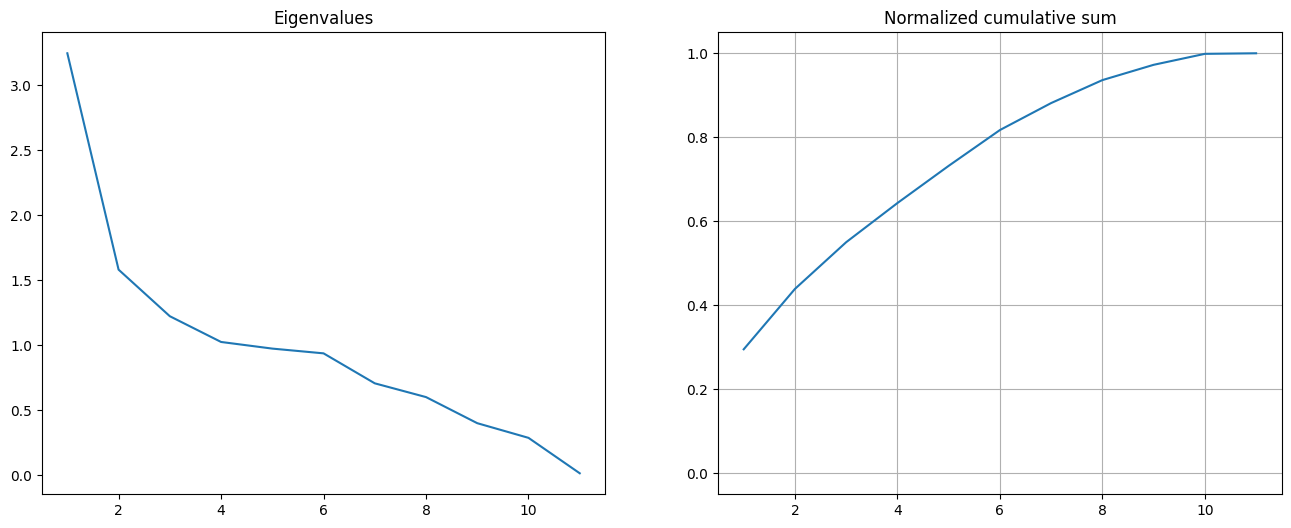

In [11]:
x_ = range(1,len(eigvals) + 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(x=x_, y=eigvals, ax=axes[0])
sns.lineplot(x=x_, y=np.cumsum(eigvals/np.sum(eigvals)), ax=axes[1])
axes[1].grid()

axes[0].set_title('Eigenvalues')
axes[1].set_title('Normalized cumulative sum')
axes[1].set_ylim(-0.05, 1.05)

plt.show()

We see that in the new vector space the last 11th dimension can be safely ignored. Unfortunatey we can't reduce more than that.


Just satisfying curiosity: let's pick the first five components (dimensions) and take a look at the 2D projections. Unfortunately no particular grouping is spotted, this means that the clustering won't be trivial.

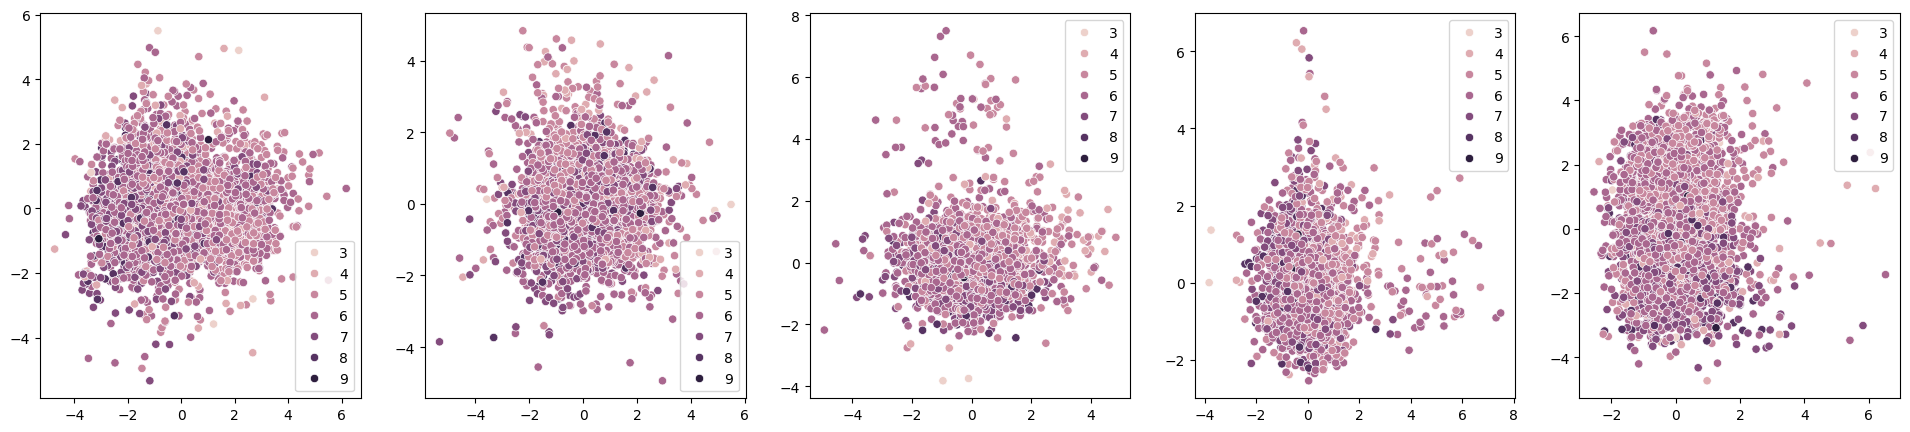

In [12]:
svd = TruncatedSVD(random_state=0, n_components=5)
u = svd.fit_transform(A_train)

fig, axes = plt.subplots(1, 5, figsize=(24, 5))
for i in range(5):
    sns.scatterplot(x=u[:,i], y=u[:,(i+1) % 5], hue=y_train, ax=axes[i])
plt.show()

## Models

### 1. Hierarchical (dendrogram) clustering


There are only 7 target categories, but it's pretty much impossible to come up with an adequately accurate clustering of the dataset into just 7 clusters. I scatterplotted to multiple projections and couldn't identify continuous regions of the same quality. Instead I'm fragmenting the dataset into much more clusters and assigning the labels 3-9 (as the `mean` of the true labels of the training samples forming the particular cluster), with this approach there may be more than multiple clusters having the same label. More clusters would mean finer (more granular) fitting to the training dataset, but the test dataset works as the regularizer and prevents overfitting.

With every clustering this procedure runs:
- Assign the cluster labels
- Find the cluster centroids
- For each test sample find the closest centroid `pairwise_distances_argmin`
- It becomes the `yhat_test` label of the given sample
- Calculate the RMSE looking at the difference between the true `y_test` and `yhat_test`



I'm running tests for all the valid combinations of methods and metrics, for "reasonable" numbers of clusters to probe (`probe_n_clust`). Besides that I'm repeating the same in 3 different vector spaces: the results of SVD-compression to 2D, 5D, and 10D.

In [13]:
def run_hierarchy_probe_n_cluster(probe_n_clusters, U_train, U_test, y_train, y_test, method, metric):
    rmses_train = []
    rmses_test = []

    for n_clust in probe_n_clusters:
        Z = linkage(U_train, method=method, metric=metric)
        train_clusters = fcluster(Z, t=n_clust, criterion='maxclust')
        unique_clusters = np.unique(train_clusters)

        centroids = np.array([U_train[train_clusters == clust_id].mean(axis=0) for clust_id in unique_clusters])
        labels = np.array([np.round(y_train[train_clusters == clust_id].mean()) for clust_id in unique_clusters]).astype(int)

        train_pred_clusters = np.zeros(train_clusters.shape[0]).astype(int)
        for i,clust_id in enumerate(unique_clusters):
            train_pred_clusters[train_clusters == clust_id] = i
        yhat_train = labels[train_pred_clusters]

        test_pred_clusters = pairwise_distances_argmin(U_test, centroids, metric=metric)
        yhat_test = labels[test_pred_clusters]

        rmses_train.append(rmse(y_train, yhat_train))
        rmses_test.append(rmse(y_test, yhat_test))

    return rmses_train, rmses_test


In [14]:
methods = ['single', 'complete', 'weighted']
metric = ['euclidean','cosine']
valid_combinations = [('weighted', 'euclidean'), ('ward', 'euclidean')]
valid_combinations.extend(itertools.product(methods, metric))
print(valid_combinations)

[('weighted', 'euclidean'), ('ward', 'euclidean'), ('single', 'euclidean'), ('single', 'cosine'), ('complete', 'euclidean'), ('complete', 'cosine'), ('weighted', 'euclidean'), ('weighted', 'cosine')]


**Two main dimensions (n=2)**

In [15]:
svd = TruncatedSVD(random_state=0, n_components=2)
svd.fit(A_train)

U_train = svd.transform(A_train)
U_test = svd.transform(A_test)

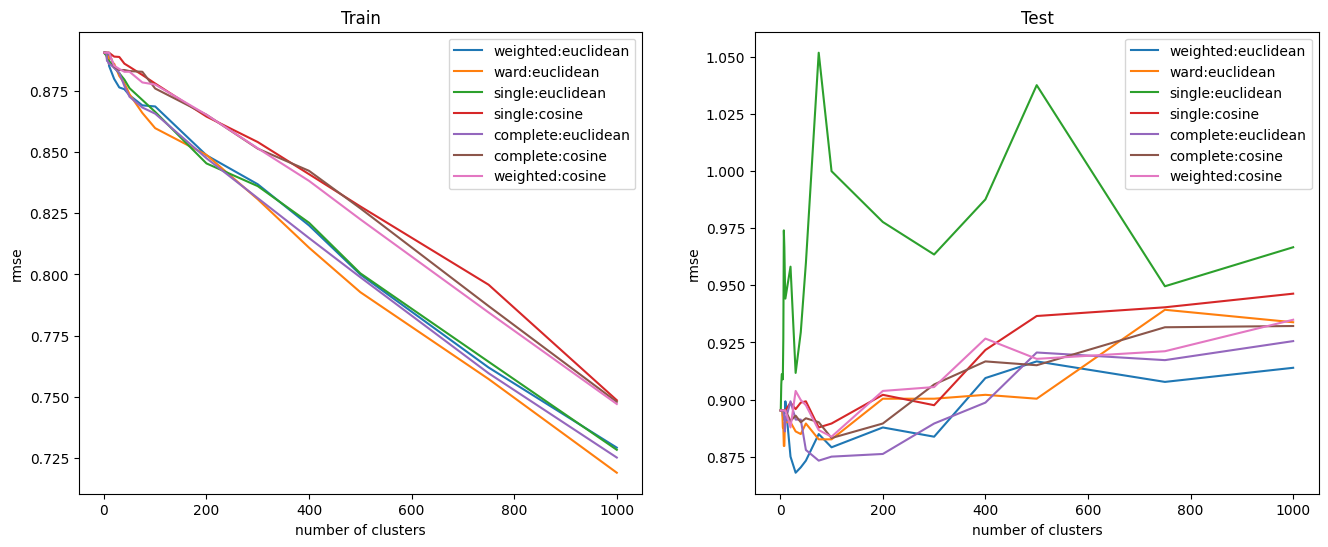

In [16]:
probe_n_clust = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,75,100,200,300,400,500,750,1000]

results = dict()
for method,metric in valid_combinations:
    key = f'{method}:{metric}'
    results[key] = run_hierarchy_probe_n_cluster(probe_n_clust, U_train, U_test, y_train, y_test, method=method, metric=metric)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for k,v in results.items():
    sns.lineplot(x=probe_n_clust, y=v[0], label=k, ax=axes[0])    
    sns.lineplot(x=probe_n_clust, y=v[1], label=k, ax=axes[1])

axes[0].set_title('Train')
axes[0].set_ylabel('rmse')
axes[0].set_xlabel('number of clusters')

axes[1].set_title('Test')
axes[1].set_ylabel('rmse')
axes[1].set_xlabel('number of clusters')

plt.show()

**Something in the middle (n=5)**

In [17]:
svd = TruncatedSVD(random_state=0, n_components=5)
svd.fit(A_train)

U_train = svd.transform(A_train)
U_test = svd.transform(A_test)

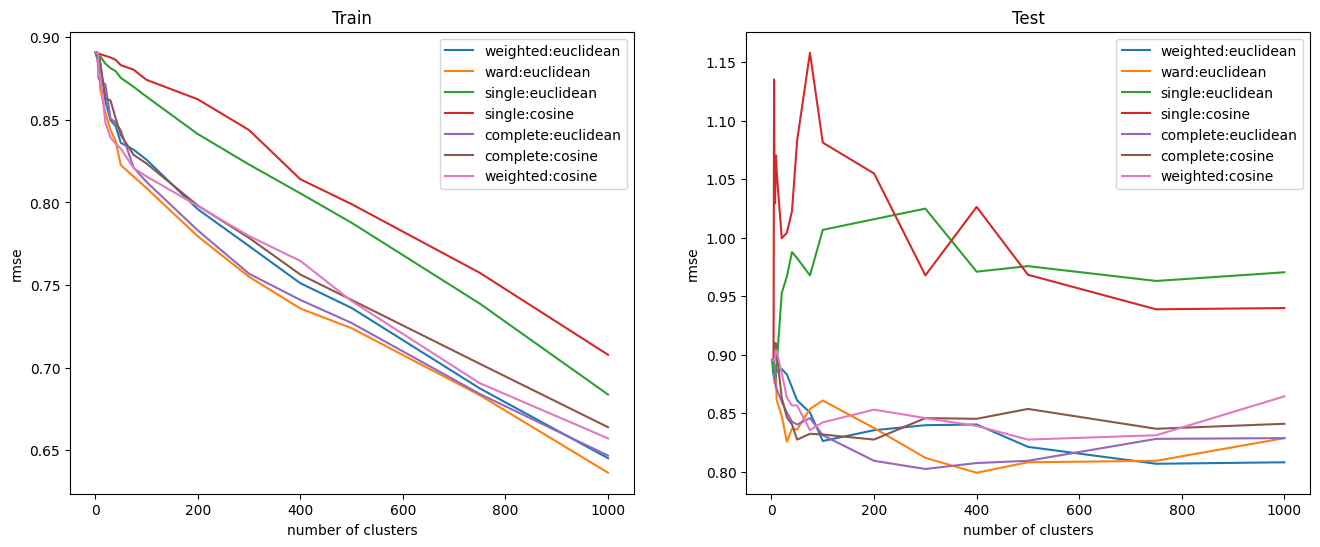

In [18]:
probe_n_clust = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,75,100,200,300,400,500,750,1000]

results = dict()
for method,metric in valid_combinations:
    key = f'{method}:{metric}'
    results[key] = run_hierarchy_probe_n_cluster(probe_n_clust, U_train, U_test, y_train, y_test, method=method, metric=metric)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for k,v in results.items():
    sns.lineplot(x=probe_n_clust, y=v[0], label=k, ax=axes[0])    
    sns.lineplot(x=probe_n_clust, y=v[1], label=k, ax=axes[1])

axes[0].set_title('Train')
axes[0].set_ylabel('rmse')
axes[0].set_xlabel('number of clusters')

axes[1].set_title('Test')
axes[1].set_ylabel('rmse')
axes[1].set_xlabel('number of clusters')

plt.show()

**All useful dimensions (n=10)**

In [19]:
svd = TruncatedSVD(random_state=0, n_components=10)
svd.fit(A_train)

U_train = svd.transform(A_train)
U_test = svd.transform(A_test)

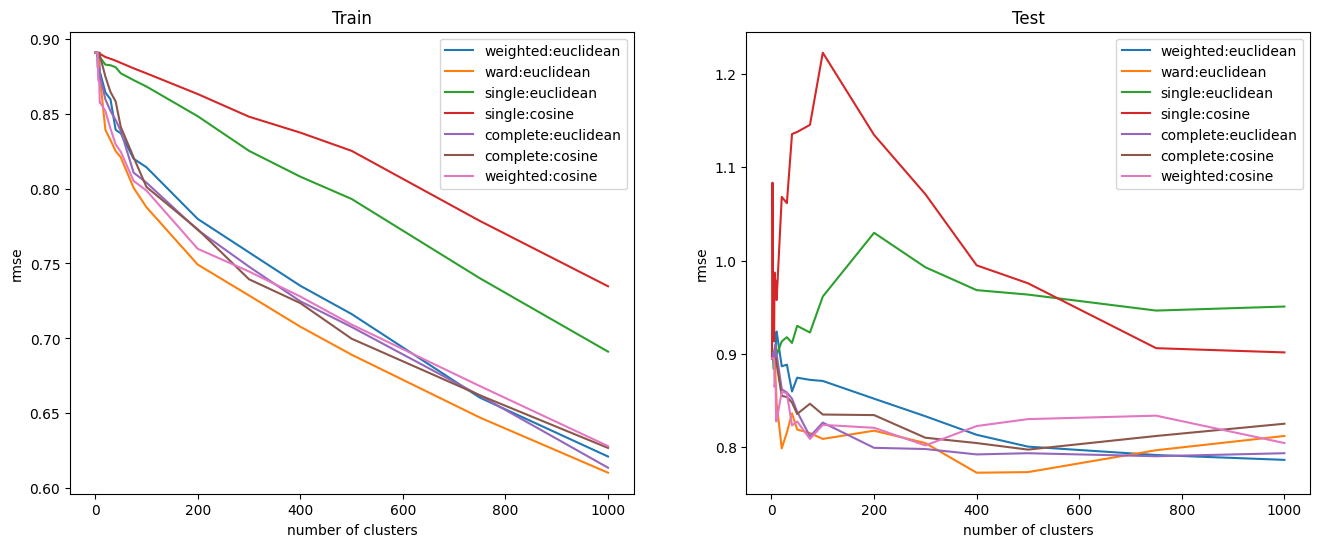

In [20]:
probe_n_clust = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,75,100,200,300,400,500,750,1000]

results = dict()
for method,metric in valid_combinations:
    key = f'{method}:{metric}'
    results[key] = run_hierarchy_probe_n_cluster(probe_n_clust, U_train, U_test, y_train, y_test, method=method, metric=metric)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for k,v in results.items():
    sns.lineplot(x=probe_n_clust, y=v[0], label=k, ax=axes[0])    
    sns.lineplot(x=probe_n_clust, y=v[1], label=k, ax=axes[1])

axes[0].set_title('Train')
axes[0].set_ylabel('rmse')
axes[0].set_xlabel('number of clusters')

axes[1].set_title('Test')
axes[1].set_ylabel('rmse')
axes[1].set_xlabel('number of clusters')

plt.show()


1. I'm staying in 10D, in more compact representations test RMSE didn't dip under 0.8
2. `ward:euclidean` with 400 clusters works the best.

In [21]:
idx = np.argmin(results['ward:euclidean'][1])
print(f'n_clusters={probe_n_clust[idx]}, test rmse={results['ward:euclidean'][1][idx]}')

n_clusters=400, test rmse=0.7724795578842378


Now rebuilding the clusters with the best hyperparameters found, and displaying the confusion matrix

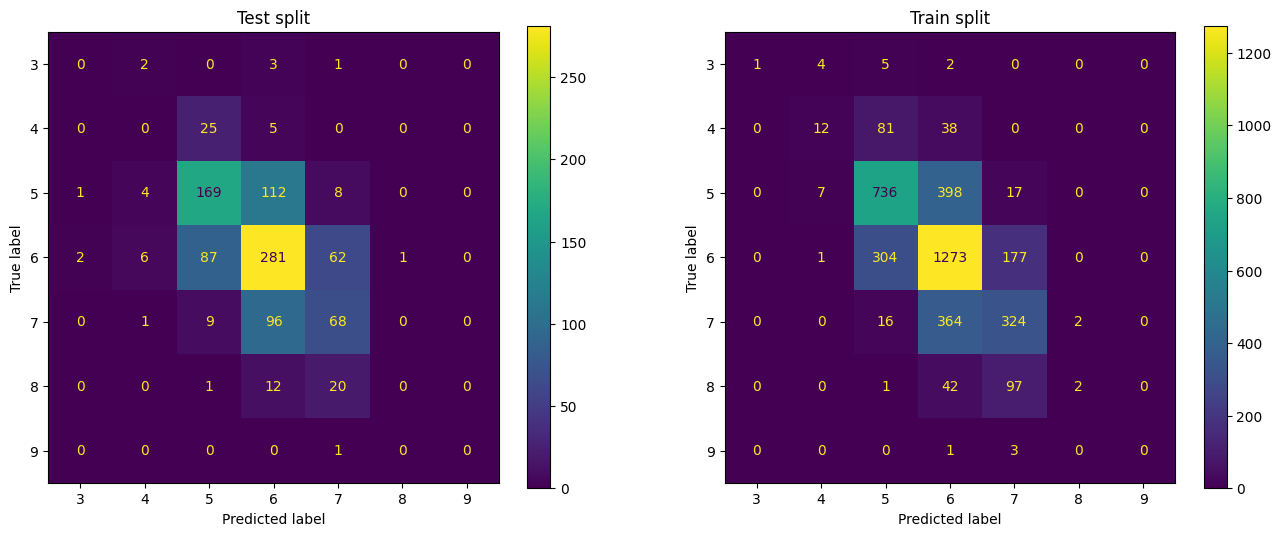

In [22]:
Z = linkage(U_train, method='ward', metric='euclidean')
train_clusters = fcluster(Z, t=400, criterion='maxclust')
unique_clusters = np.unique(train_clusters)

centroids = np.array([U_train[train_clusters == clust_id].mean(axis=0) for clust_id in unique_clusters])
labels = np.array([np.round(y_train[train_clusters == clust_id].mean()) for clust_id in unique_clusters]).astype(int)

train_pred_clusters = np.zeros(train_clusters.shape[0]).astype(int)
for i,clust_id in enumerate(unique_clusters):
    train_pred_clusters[train_clusters == clust_id] = i
yhat_train = labels[train_pred_clusters]

test_pred_clusters = pairwise_distances_argmin(U_test, centroids, metric=metric)
yhat_test = labels[test_pred_clusters]


# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm = confusion_matrix(y_test, np.clip(np.round(yhat_test), 3, 9))
ConfusionMatrixDisplay(cm, display_labels=range(3,10)).plot(ax=axes[0])

cm = confusion_matrix(y_train, np.clip(np.round(yhat_train), 3, 9))
ConfusionMatrixDisplay(cm, display_labels=range(3,10)).plot(ax=axes[1])

axes[0].set_title('Test split')
axes[1].set_title('Train split')
plt.show()

### 2. K-Means


For K-Means probing slightly different list of `probe_n_clust`, not probing 2D nor 5D subspaces. Besides that KMeans class has a built-in `predict` method, we don't need to mimic it by searching the closest centroid explicitly.

In [23]:
svd = TruncatedSVD(random_state=0, n_components=10)
svd.fit(A_train)

U_train = svd.transform(A_train)
U_test = svd.transform(A_test)

In [32]:
probe_n_clust = [10,20,30,40,50,75,100,200,300,400,500,750,1000,1250,1500,1750,2000]

rmses_train = []
rmses_test = []

for n_clust in probe_n_clust:
    km = KMeans(n_clusters=n_clust, n_init=10, random_state=42).fit(U_train)
    train_clusters = km.predict(U_train)

    unique_clusters = np.unique(train_clusters)
    labels = np.array([np.round(y_train[train_clusters == clust_id].mean()) for clust_id in unique_clusters]).astype(int)

    yhat_train = labels[train_clusters]
    rmses_train.append(rmse(y_train, yhat_train))

    test_clusters = km.predict(U_test)
    yhat_test = labels[test_clusters]
    rmses_test.append(rmse(y_test, yhat_test))

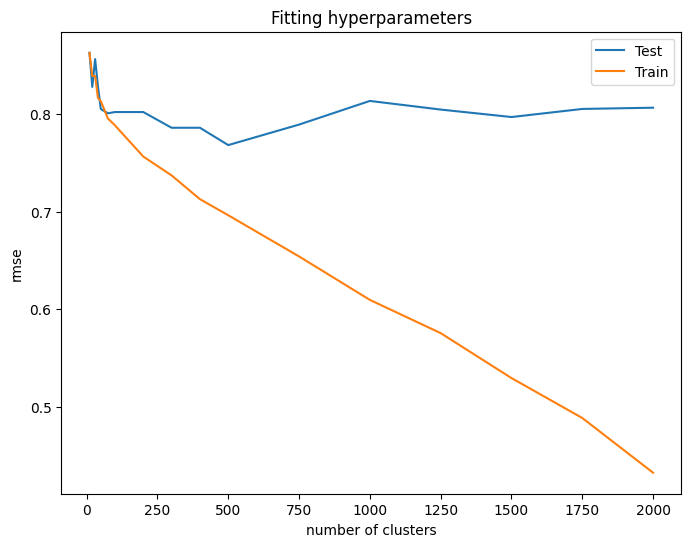

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
sns.lineplot(x=probe_n_clust, y=rmses_test, label='Test')
sns.lineplot(x=probe_n_clust, y=rmses_train, label='Train')
axes.set_title('Fitting hyperparameters')
axes.set_ylabel('rmse')
axes.set_xlabel('number of clusters')
plt.show()

In [35]:
idx = np.argmin(rmses_test)
print(f'n_clusters={probe_n_clust[idx]}, test rmse={rmses_test[idx]}')

n_clusters=500, test rmse=0.7684942541284576


In [36]:
km = KMeans(n_clusters=500, n_init=10, random_state=42).fit(U_train)
train_clusters = km.predict(U_train)

unique_clusters = np.unique(train_clusters)
labels = np.array([np.round(y_train[train_clusters == clust_id].mean()) for clust_id in unique_clusters]).astype(int)

yhat_train = labels[train_clusters]

test_clusters = km.predict(U_test)
yhat_test = labels[test_clusters]

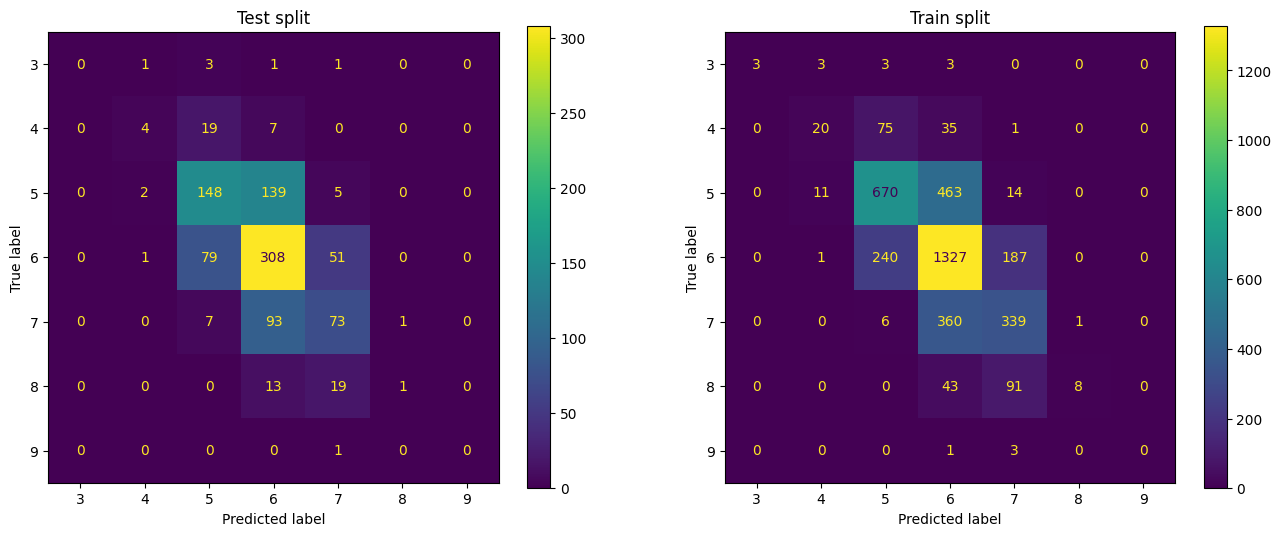

In [37]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm = confusion_matrix(y_test, np.clip(np.round(yhat_test), 3, 9))
ConfusionMatrixDisplay(cm, display_labels=range(3,10)).plot(ax=axes[0])

cm = confusion_matrix(y_train, np.clip(np.round(yhat_train), 3, 9))
ConfusionMatrixDisplay(cm, display_labels=range(3,10)).plot(ax=axes[1])

axes[0].set_title('Test split')
axes[1].set_title('Train split')
plt.show()


Let's scatterplot differences between predicted and the actual qualities, projecting it to the plane of the first two dimensions.

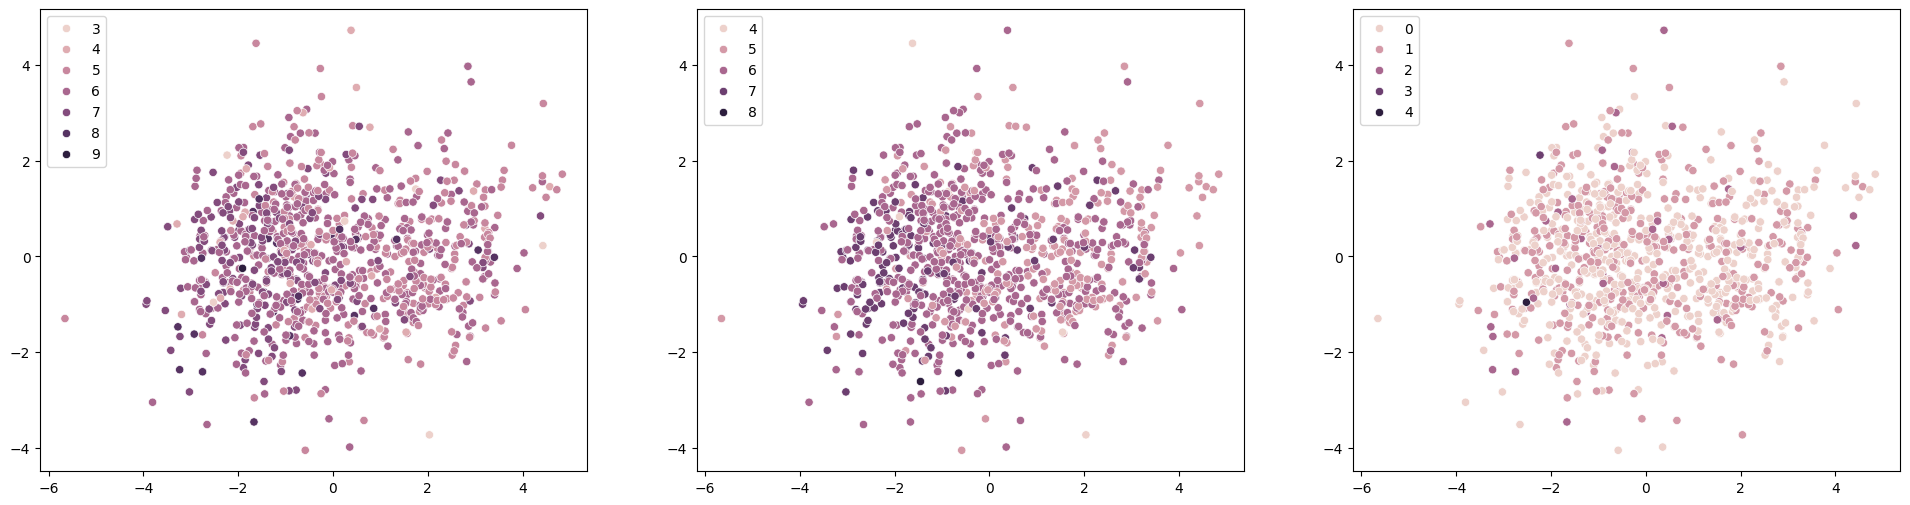

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
sns.scatterplot(x=U_test[:,0], y=U_test[:,1], hue=y_test, ax=axes[0])
sns.scatterplot(x=U_test[:,0], y=U_test[:,1], hue=yhat_test, ax=axes[1])
sns.scatterplot(x=U_test[:,0], y=U_test[:,1], hue=np.abs(y_test-yhat_test), ax=axes[2])
plt.show()

# Summary


Even in the datasets with no easy geometrical interpretation some basic unsupervised approaches can (to some extent) approximate the internal structure.


Of the two approaches:
- *KMeans* is more convenient and results in a little smaller test RMSE.
- On the other hand *Hierarchical* allows testing different numbers of clusters without rebuilding the tree, this makes hyperparameters tuning really fast.


| Method | n-clusters | Method/Metric | RMSE (test split) |
|----------|----------|----------|----------|
|Hierarchy clustering | 400 | Ward/Euclidean | 0.7724795578842378|
|K-Means | 500 | Centroid/Euclidean | 0.7684942541284576|